## Simple DCAE(Denoising Convolutional Auto-Encoder) for Speech Signal
- Simple Auto-Encoder structure using Convolution/Transposed Convolution
- Acoustic Features(e.g. linear spectrogram, mel spectrogram) with **variable length** can be used as input.



In [1]:
import os
import glob
import numpy as np
import soundfile as sf
import librosa

from dcae import SimpleDCAE
from noisy import get_noisy_sig
from dataloader import YesNoDataset, YesNoPairs, data_preprocessing
from trainer import Trainer, MaskedMSELoss

import torch
from torch.utils.data import DataLoader

In [2]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

#### create noisy signal dataset(with a specified SNR)
* noisy signal = clean signal + noise signal
    * noise signal: among noise signal files in noises B, only select files that contain "Giggle" or "fan" in file name.
    * randomly selected for each signal.

In [3]:
yesno = YesNoDataset('./waves_yesno/')

In [4]:
DATA_DIR = "./waves_yesno/"
NOISE_DIR = "./noisesB/"

noise_files = glob.glob(NOISE_DIR+"*.wav")
selected_noises = [f for f in noise_files if ('Giggle' in f) or ('fan' in f)] 
print(f"selected noise files: {selected_noises}")

np.random.seed(111)
noise_indices = np.random.randint(0, len(selected_noises), len(yesno))
print(noise_indices)

selected noise files: ['./noisesB/fan1.wav', './noisesB/fan2.wav', './noisesB/Giggle+3.wav', './noisesB/Giggle+6.wav', './noisesB/Giggle+5.wav', './noisesB/Giggle+4.wav']
[4 4 4 4 3 1 2 2 0 1 4 2 1 0 0 4 2 5 0 5 4 2 4 5 5 0 5 2 3 4 3 5 1 2 3 1 3
 0 5 4 1 2 3 3 1 0 3 3 1 4 5 3 5 0 3 0 1 1 4 3]


In [5]:
import shutil
snr = 5
SAVE_DIR = f"./snr{snr}/"
NOISY_DIR = f'{SAVE_DIR}yesno_noisy_{snr}/'
NOISE_DIR = f'{SAVE_DIR}yesno_noise_{snr}/'

create_new = True

if create_new:
    try:
        if os.path.exists(NOISY_DIR):
            shutil.rmtree(NOISY_DIR)
        
        if os.path.exists(NOISE_DIR):
            shutil.rmtree(NOISE_DIR)
        
        os.makedirs(NOISY_DIR)
        os.makedirs(NOISE_DIR)
        for i in range(len(yesno)):
            # load clean signal
            sig, sr, labels = yesno[i]
            fn = yesno.file_list[i].replace(yesno.dir_path, '')
            noisy_fn = f"noisy_{snr}_{yesno.file_list[i].replace(yesno.dir_path, '')}"
            # load noise signal
            noise, sr = librosa.load(selected_noises[noise_indices[i]])
            noise_fn = f"noise_{snr}_{yesno.file_list[i].replace(yesno.dir_path, '')}"
            ## get noisy signal(clean + noise ~ SNR ratio)
            noisy = get_noisy_sig(sig, noise, snr = snr)
            noisy_fn_path =  NOISY_DIR + noisy_fn
            noise_fn_path =  NOISE_DIR + noise_fn
            sf.write(file= noisy_fn_path, data=noisy, samplerate=sr)
            sf.write(file= noise_fn_path, data=noisy, samplerate=sr)
            print(f"Saved: {fn} ---> {noisy_fn_path}")
    except:
        raise OSError

Saved: 0_0_1_0_0_0_1_0.wav ---> ./snr5/yesno_noisy_5/noisy_5_0_0_1_0_0_0_1_0.wav
Saved: 1_1_1_0_1_0_1_0.wav ---> ./snr5/yesno_noisy_5/noisy_5_1_1_1_0_1_0_1_0.wav
Saved: 1_1_1_0_1_0_1_1.wav ---> ./snr5/yesno_noisy_5/noisy_5_1_1_1_0_1_0_1_1.wav
Saved: 1_1_0_1_1_0_0_1.wav ---> ./snr5/yesno_noisy_5/noisy_5_1_1_0_1_1_0_0_1.wav
Saved: 0_0_0_1_0_0_0_1.wav ---> ./snr5/yesno_noisy_5/noisy_5_0_0_0_1_0_0_0_1.wav
Saved: 0_0_1_0_1_0_0_0.wav ---> ./snr5/yesno_noisy_5/noisy_5_0_0_1_0_1_0_0_0.wav
Saved: 0_1_0_1_1_1_0_0.wav ---> ./snr5/yesno_noisy_5/noisy_5_0_1_0_1_1_1_0_0.wav
Saved: 0_0_1_0_1_0_0_1.wav ---> ./snr5/yesno_noisy_5/noisy_5_0_0_1_0_1_0_0_1.wav
Saved: 1_1_1_0_0_0_0_1.wav ---> ./snr5/yesno_noisy_5/noisy_5_1_1_1_0_0_0_0_1.wav
Saved: 1_1_0_1_0_1_1_0.wav ---> ./snr5/yesno_noisy_5/noisy_5_1_1_0_1_0_1_1_0.wav
Saved: 1_1_1_0_0_1_0_1.wav ---> ./snr5/yesno_noisy_5/noisy_5_1_1_1_0_0_1_0_1.wav
Saved: 0_0_1_0_0_1_1_0.wav ---> ./snr5/yesno_noisy_5/noisy_5_0_0_1_0_0_1_1_0.wav
Saved: 0_0_1_0_0_1_1_1.wav -

#### Dataset
* ```YesNoPairs``` dataset includes clean & noisy signal pairs.
* Split dataset into train/test(50:10) dataset randomly (for evaluating).


In [6]:
CLEAN_PATH = f"./waves_yesno/"
NOISY_PATH = f"./snr{snr}/yesno_noisy_5/"
NOISE_PATH = f"./snr{snr}/yesno_noise_5/"
yesno_pairs = YesNoPairs(clean_path= CLEAN_PATH,
                         noisy_path= NOISY_PATH)
torch.manual_seed(0)
trainset, validset = torch.utils.data.random_split(yesno_pairs, [50,10] )

##### Data loader
* ```data_preprocessing``` in ```DataLoader``` extracts mel-spectrogram of each signal.

In [7]:
mel_kwargs = {'n_mels': 128, 'fmax': 5000, 'fmin': 30}
train_loader = DataLoader(trainset, batch_size=5, shuffle=True,  collate_fn= lambda x: data_preprocessing(x, mel_kwargs))
valid_loader = DataLoader(validset, batch_size=5, shuffle=False,  collate_fn= lambda x: data_preprocessing(x, mel_kwargs))


#### Training
* ```MaskedMSELoss```: **ignoring padding area in MSE loss computation.**

In [8]:
# Define model, crit, optimizer, ...
device = 'cpu'
model = SimpleDCAE().to(device) 
crit = MaskedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,factor=.5,  patience = 2,  min_lr=1e-5, verbose  =True )
n_epochs = 40


# Define trainer
trainer = Trainer(model, crit= crit, optimizer = optimizer, scheduler = scheduler)


# Training model
for epoch in range(n_epochs):
    total_train_loss = trainer.train(train_loader)
    total_val_loss = trainer.validate(valid_loader)
    trainer.scheduler.step(total_val_loss)
    print(f"Epoch {epoch+1}: train_loss: {total_train_loss/len(train_loader)} val_loss : {total_val_loss/len(valid_loader)}")



  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 1: train_loss: 2569.3952026367188 val_loss : 1680.689697265625


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 2: train_loss: 302.2328399658203 val_loss : 378.5828094482422


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 3: train_loss: 218.35894927978515 val_loss : 471.33123779296875


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 4: train_loss: 167.36883239746095 val_loss : 169.32923889160156


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 5: train_loss: 143.97761306762695 val_loss : 155.23392486572266


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 6: train_loss: 129.3194435119629 val_loss : 145.09442138671875


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 7: train_loss: 127.7520362854004 val_loss : 140.55206298828125


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 8: train_loss: 124.47579193115234 val_loss : 135.0974884033203


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 9: train_loss: 124.62730712890625 val_loss : 132.62696838378906


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 10: train_loss: 116.21518020629883 val_loss : 124.47151565551758


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 11: train_loss: 112.70304107666016 val_loss : 138.82691955566406


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 12: train_loss: 105.87871170043945 val_loss : 123.73443984985352


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 13: train_loss: 100.32287521362305 val_loss : 127.25765609741211


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 14: train_loss: 99.47323913574219 val_loss : 104.78351211547852


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 15: train_loss: 90.3963409423828 val_loss : 100.12033081054688


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 16: train_loss: 83.46016464233398 val_loss : 93.83840942382812


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 17: train_loss: 81.73882293701172 val_loss : 92.08062362670898


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 18: train_loss: 79.72147521972656 val_loss : 90.23756408691406


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 19: train_loss: 75.7700569152832 val_loss : 84.8411750793457


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 20: train_loss: 73.93976669311523 val_loss : 83.42779922485352


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 21: train_loss: 74.39974746704101 val_loss : 84.97540283203125


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 22: train_loss: 69.50756874084473 val_loss : 88.3479232788086


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 00023: reducing learning rate of group 0 to 5.0000e-03.
Epoch 23: train_loss: 70.7632900238037 val_loss : 90.6179084777832


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 24: train_loss: 68.55066108703613 val_loss : 78.17029190063477


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 25: train_loss: 64.50256004333497 val_loss : 77.05628204345703


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 26: train_loss: 63.48029747009277 val_loss : 112.872802734375


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 27: train_loss: 61.64343528747558 val_loss : 78.36274337768555


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 28: train_loss: 65.36238517761231 val_loss : 71.97163391113281


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 29: train_loss: 61.04717788696289 val_loss : 75.49095916748047


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 30: train_loss: 62.65744895935059 val_loss : 71.86599731445312


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 31: train_loss: 60.864645385742186 val_loss : 71.21068572998047


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 32: train_loss: 59.202508544921876 val_loss : 71.81729507446289


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 33: train_loss: 59.657934951782224 val_loss : 75.59001922607422


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 34: train_loss: 56.158538818359375 val_loss : 67.98739624023438


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 35: train_loss: 57.92032318115234 val_loss : 70.1718978881836


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 36: train_loss: 56.11239166259766 val_loss : 69.36903762817383


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 00037: reducing learning rate of group 0 to 2.5000e-03.
Epoch 37: train_loss: 56.53882102966308 val_loss : 75.10767364501953


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 38: train_loss: 56.104427337646484 val_loss : 66.81941604614258


  0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 39: train_loss: 54.92518348693848 val_loss : 67.73552703857422


100%|██████████| 2/2 [00:06<00:00,  3.02s/batch, valid_loss=64.9]

Epoch 40: train_loss: 52.978355407714844 val_loss : 65.52754974365234


### Denoised Speech
#### - Mel Spectrogram

In [9]:
import matplotlib.pyplot as plt
import IPython.display as ipd
valid_loader = DataLoader(validset, batch_size=5, shuffle=False,  collate_fn= lambda x: data_preprocessing(x, mel_kwargs))
test_samples = next(iter(valid_loader))
test_clean, test_noisy, input_lengths, mask_ind = test_samples
model.eval()
test_denoised = model(test_noisy)
test_noise_sep = test_noisy - test_denoised

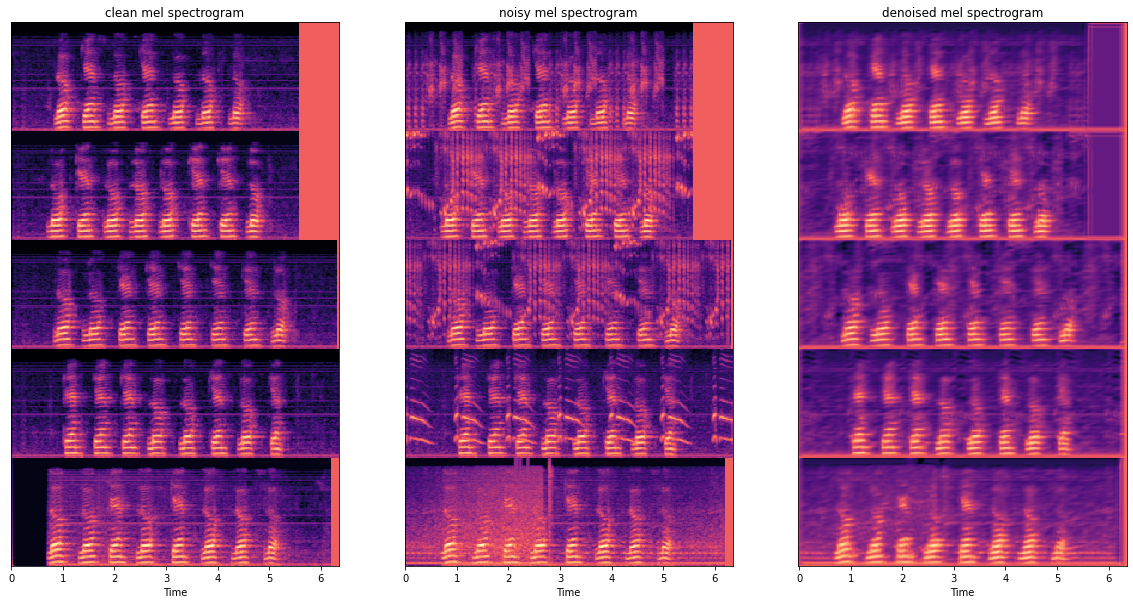

In [10]:
fig, axes = plt.subplots(1,3, figsize = (20,10))
librosa.display.specshow(test_clean.reshape(-1, test_clean.shape[-1]).detach().numpy(), x_axis = 'time', ax = axes[0], fmax=mel_kwargs['fmax'], fmin = mel_kwargs['fmin'], cmap = 'magma')
librosa.display.specshow(test_noisy.reshape(-1, test_noisy.shape[-1]).detach().numpy(), x_axis = 'time', ax = axes[1], fmax=mel_kwargs['fmax'], fmin = mel_kwargs['fmin'], cmap = 'magma')
librosa.display.specshow(test_denoised.reshape(-1, test_denoised.shape[-1]).detach().numpy(), x_axis = 'time', ax = axes[2], fmax=mel_kwargs['fmax'], fmin = mel_kwargs['fmin'], cmap = 'magma')

axes[0].set_title('clean mel spectrogram')
axes[1].set_title('noisy mel spectrogram')
axes[2].set_title('denoised mel spectrogram')

plt.show()


#### - Audio

In [11]:
from utils import  show_denoising

sample 1
clean


noisy


denoised


noisy - denoised


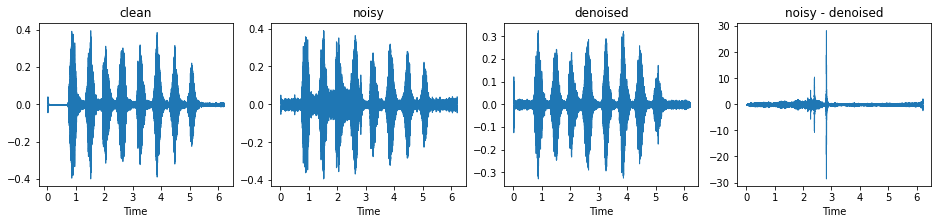

sample 2
clean


noisy


denoised


noisy - denoised


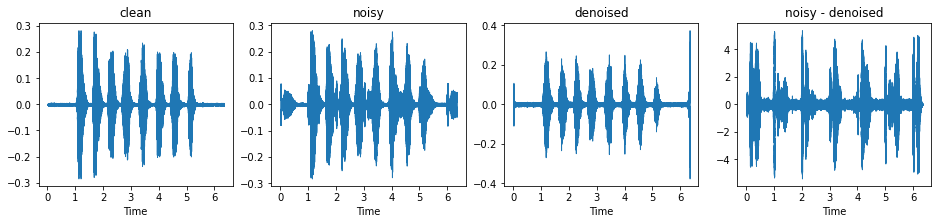

sample 3
clean


noisy


denoised


noisy - denoised


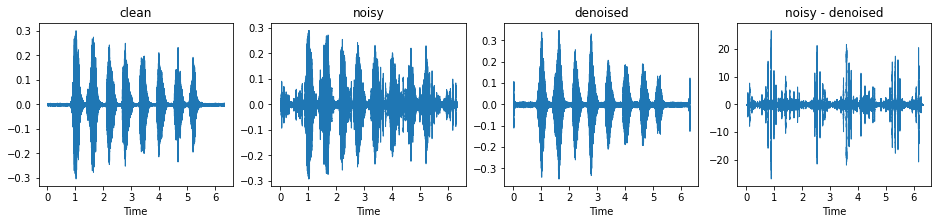

sample 4
clean


noisy


denoised


noisy - denoised


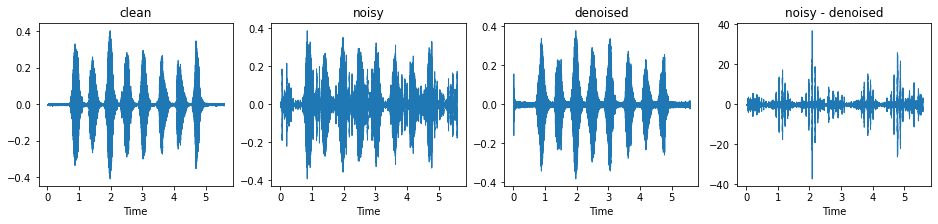

sample 5
clean


noisy


denoised


noisy - denoised


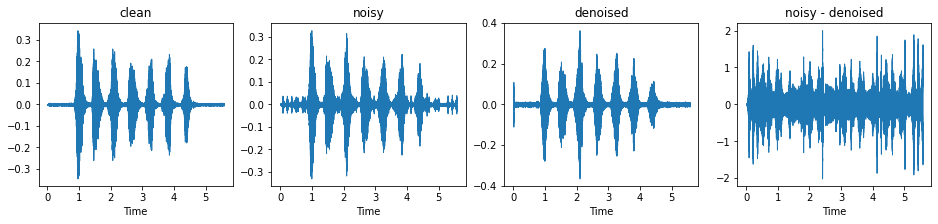

In [18]:
for i in range(len(test_clean)):
    print(f"sample {i+1}")
    show_denoising(clean = test_clean[i], noisy = test_noisy[i], denoised=test_denoised[i], separated_noise=test_noise_sep[i],  input_lengths = [input_lengths[i]], fmax = mel_kwargs['fmax'], fmin =mel_kwargs['fmin'])
    plt.show()

In [15]:
## +) model save
# torch.save(model.state_dict(), f'./model/dcae.pt')